# Credit Risk PD Modeling 

In [24]:
# Installation 
# !pip install pandas numpy matplotlib seaborn scikit-learn scipy

# Core Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)

# Statistics
from scipy.stats import ks_2samp

# Set plotting style for better visualizations
sns.set_style("whitegrid")

### Load the data
#### Data Dictionary:
- loan_id:	Unique loan identifier 
- income:     Borrower annual income in USD
- age:        Borrower age in years 
- employment_years:	Number of years the borrower has been employed 
- credit_score:	Borrower credit score 
- loan_purpose:	Purpose of the loan ( e.g., car, home, education, business)
- loan_term:      Loan term duration (36 months, 60 months)
- loan_amount:    Loan amount in USD 
- loan_status:    "Loan status of the borrower has 4 levels default- those that are already defaulted in grace period - they are 16-30 days past due date
- current - they are upto date, no arrears at the moment
- 90+dpd - 90 days past due date"


In [25]:
try:
    df = pd.read_csv('loan_data.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'loan_data.csv' file not found. Cannot proceed.")
    exit() 

Data loaded successfully.


### Data Understanding and Cleaning

In [26]:
print(" DATA UNDERSTANDING AND CLEANING ")

# Define the columns
numerical_cols = ['income', 'age', 'employment_years', 'credit_score', 'loan_amount']

# Summary of Structure 
print("\n Data Structure Summary ")
print(f"Initial Shape: {df.shape}")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Identify and Handle Missing Values 
print("\n Missing Value Handling ")

# Define Target Variable (Default)
def map_loan_status(status):
    if status in ['default', '90+dpd']:
        return 1
    elif status in ['current', 'in grace period']:
        return 0
    return np.nan
df['Default'] = df['loan_status'].apply(map_loan_status)
print(f"Default Target variable created. Default Rate: {df['Default'].mean():.4f}")

# Impute Numerical (income, loan_amount) with Median
numerical_cols_with_na = ['income', 'loan_amount']
for col in numerical_cols_with_na:
    df[col].fillna(df[col].median(), inplace=True)

print("\n Missing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Detect and comment on Outliers 
print("\n Outlier Detection (1.5 * IQR Rule) ")
for col in ['income', 'loan_amount', 'credit_score']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = df[df[col] > upper_bound].shape[0]
    print(f"'{col}': {outliers_count} observations above the upper 1.5*IQR bound.")
print("\nComment: Outliers are retained for their predictive value in risk modeling and will be scaled later.")

 DATA UNDERSTANDING AND CLEANING 

 Data Structure Summary 
Initial Shape: (2500, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_id           2500 non-null   object 
 1   income            2450 non-null   float64
 2   age               2500 non-null   int64  
 3   employment_years  2500 non-null   int64  
 4   credit_score      2500 non-null   float64
 5   loan_purpose      2470 non-null   object 
 6   loan_term         2500 non-null   object 
 7   loan_amount       2450 non-null   float64
 8   loan_status       2500 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 175.9+ KB
None

First 5 rows:
   loan_id        income  age  employment_years  credit_score loan_purpose  \
0  LN00001  59934.283060   23                 3    606.090525         home   
1  LN00002  47234.713977   51                35    6

C:\Users\USER\AppData\Local\Temp\ipykernel_25032\1147007065.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_25032\1147007065.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

### Exploratory Data Analysis (EDA)

 EXPLORATORY DATA ANALYSIS (a-c) 

 Univariate Analysis 

Numerical Descriptive Statistics:
                   count          mean           std           min  \
income            2500.0  51329.221735  21624.902955 -14825.346801   
age               2500.0     42.558000     12.722082     21.000000   
employment_years  2500.0     19.095600     11.229858      0.000000   
credit_score      2500.0    648.935145     73.480634    357.597535   
loan_amount       2500.0  20109.479160   9395.982986   5000.000000   

                           25%           50%           75%            max  
income            37741.156325  50648.011445  63557.759150  221794.290100  
age                  32.000000     43.000000     54.000000      64.000000  
employment_years      9.000000     19.000000     29.000000      39.000000  
credit_score        599.056552    649.932990    698.712496     892.823552  
loan_amount       13034.197990  19585.145145  26534.795687   51843.065686  

 Bivariate Analysis 

Average 

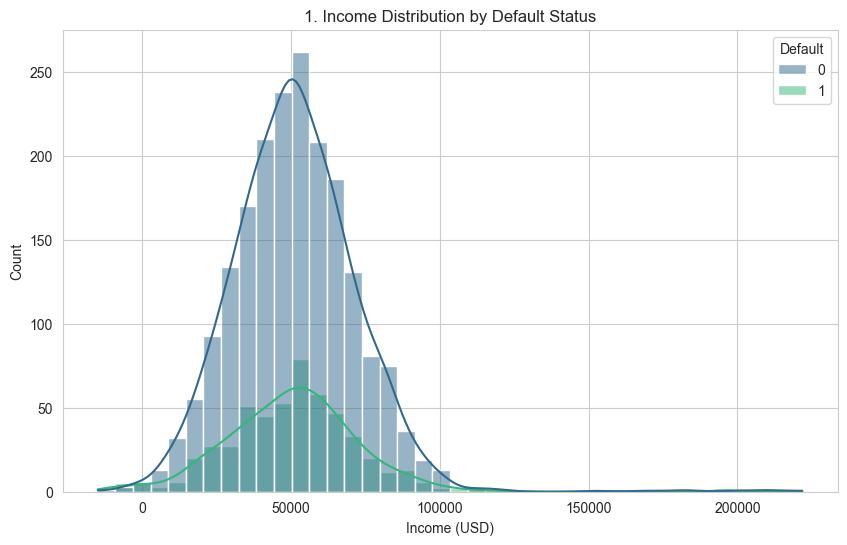

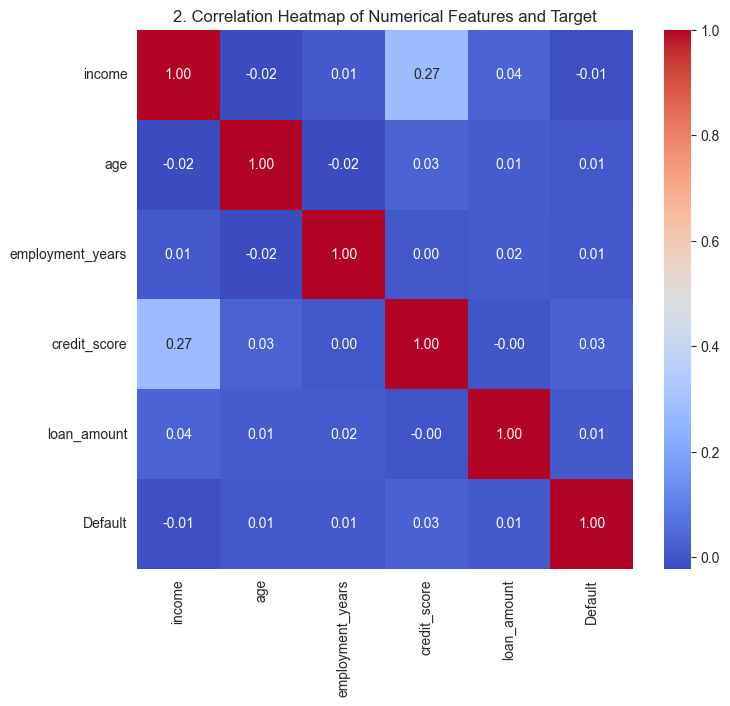

C:\Users\USER\AppData\Local\Temp\ipykernel_25032\1497608950.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_rate_by_purpose.index, y=default_rate_by_purpose.values, palette='plasma')


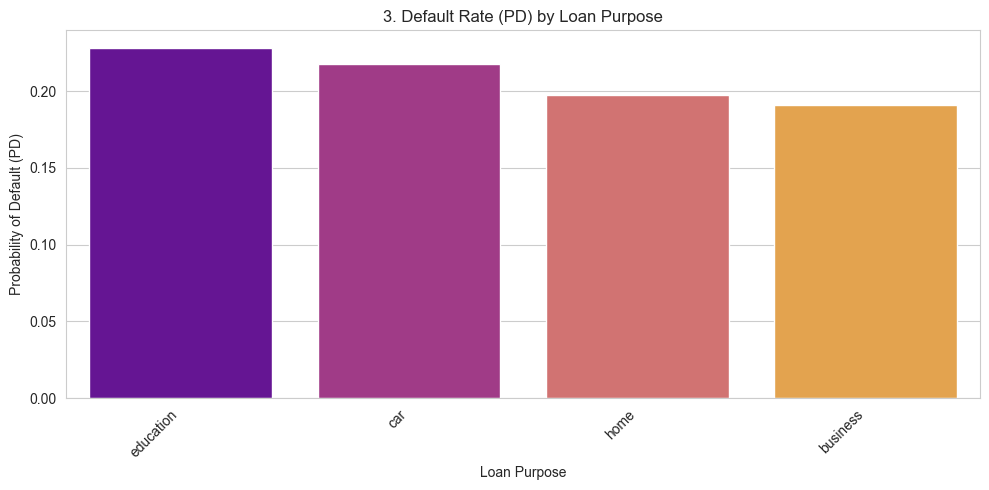

In [27]:
print(" EXPLORATORY DATA ANALYSIS (a-c) ")
target = 'Default'
categorical_cols = ['loan_purpose', 'loan_term']

#  Univariate Analysis
print("\n Univariate Analysis ")
print("\nNumerical Descriptive Statistics:")
print(df[numerical_cols].describe().T)

#  Bivariate Analysis
print("\n Bivariate Analysis ")
print("\nAverage Numerical Features by Default Status (0=Non-Default, 1=Default):")
print(df.groupby(target)[numerical_cols].mean().T)

print("\nDefault Rate by Categorical Features:")
for col in categorical_cols:
    default_rate_by_cat = df.groupby(col)[target].mean().sort_values(ascending=False)
    print(f"\n{col} Default Rate:\n{default_rate_by_cat}")

#  Visualizations 
print("\n Visualizations ")
# Vis 1: Income Distribution by Default
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='income', hue='Default', kde=True, bins=40, palette='viridis')
plt.title('1. Income Distribution by Default Status')
plt.xlabel('Income (USD)')
plt.show() # Use plt.show() in notebook

# Vis 2: Correlation Heatmap
plt.figure(figsize=(8, 7))
numerical_features_for_corr = numerical_cols + [target]
sns.heatmap(df[numerical_features_for_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('2. Correlation Heatmap of Numerical Features and Target')
plt.show()

# Vis 3: Default Rate by Loan Purpose
default_rate_by_purpose = df.groupby('loan_purpose')[target].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=default_rate_by_purpose.index, y=default_rate_by_purpose.values, palette='plasma')
plt.title('3. Default Rate (PD) by Loan Purpose')
plt.ylabel('Probability of Default (PD)')
plt.xlabel('Loan Purpose')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### -Feature Engineering

In [28]:
print(" FEATURE ENGINEERING ")
#  Create New Features and Justify 
df['DTI_Ratio'] = df['loan_amount'] / df['income']
# Justification: Core risk metric (debt burden relative to income).

bins = [0, 30, 50, df['age'].max() + 1]
labels = ['Young_HighRisk', 'Mid_Age_Stable', 'Senior_HighRisk']
df['Age_Group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
# Justification: Captures non-linear age risk (young and senior high risk).

#  Encode Categorical Variables 
categorical_cols_to_encode = ['loan_purpose', 'loan_term', 'Age_Group']
df_encoded = pd.get_dummies(df.drop(columns=['loan_status']), columns=categorical_cols_to_encode, drop_first=True)

#  Normalize/Scale Numerical Features 
features_to_scale = ['income', 'age', 'employment_years', 'credit_score', 'loan_amount', 'DTI_Ratio']
scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])
print("Feature Engineering Complete. Data is scaled and encoded.")

 FEATURE ENGINEERING 
Feature Engineering Complete. Data is scaled and encoded.


### Probability of Default (PD) Modeling 

 PD MODELING - BASELINE LOGISTIC REGRESSION 
Training set size: 2000, Test set size: 500
Baseline Logistic Regression Model Trained.

 Coefficients for Interpretation (DTI_Ratio and credit_score) 
        Feature  Coefficient (Beta)  Odds_Ratio (exp(Beta))
5     DTI_Ratio            0.627049                1.872078
3  credit_score            0.120567                1.128136

 Baseline Logistic Regression Evaluation (Shows Failure) 
Accuracy: 0.7920
Confusion Matrix (TP=0):
 [[396   0]
 [104   0]]
AUC: 0.4893
KS Statistic: 0.0806


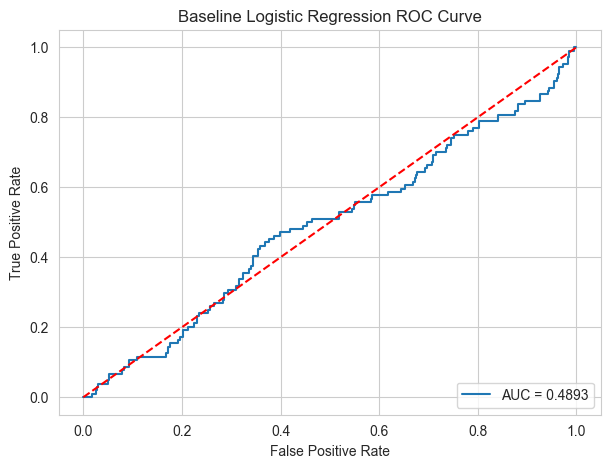

In [29]:
print(" PD MODELING - BASELINE LOGISTIC REGRESSION ")

#  Split the data (80:20 ratio) 
X = df_encoded.drop(columns=['Default', 'loan_id'])
y = df_encoded['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

#  Fit a Logistic Regression model (NO weighting - to show baseline failure) 
log_model_baseline = LogisticRegression(solver='liblinear', random_state=42)
log_model_baseline.fit(X_train, y_train)
print("Baseline Logistic Regression Model Trained.")

#  Interpret coefficients 
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient (Beta)': log_model_baseline.coef_[0],
    'Odds_Ratio (exp(Beta))': np.exp(log_model_baseline.coef_[0])
}).sort_values(by='Coefficient (Beta)', ascending=False)
print("\n Coefficients for Interpretation (DTI_Ratio and credit_score) ")
print(coefficients[coefficients['Feature'].isin(['DTI_Ratio', 'credit_score'])])

#  Evaluate the model 
y_pred_proba_base = log_model_baseline.predict_proba(X_test)[:, 1]
y_pred_base = log_model_baseline.predict(X_test)

print("\n Baseline Logistic Regression Evaluation (Shows Failure) ")
print(f"Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print("Confusion Matrix (TP=0):\n", confusion_matrix(y_test, y_pred_base))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")
ks_stat_base, _ = ks_2samp(y_pred_proba_base[y_test == 1], y_pred_proba_base[y_test == 0])
print(f"KS Statistic: {ks_stat_base:.4f}")

# Plot ROC Curve for LogReg Baseline
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_base)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_base):.4f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Baseline Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Reporting  

 IMPROVEMENT RECOMMENDATIONS (Weighted Model) 

Weighted Logistic Regression Model Trained.

 Weighted Logistic Regression Evaluation (Improved Model)
Accuracy: 0.5140
Confusion Matrix (Should show TP > 0):
 [[204 192]
 [ 51  53]]
AUC: 0.4874
KS Statistic: 0.0873


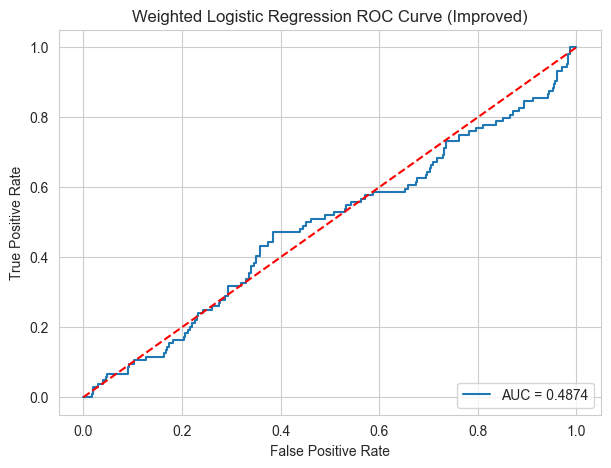


All tasks completed. Use the output metrics and visualizations for your final Task 5 report.


In [30]:
print(" IMPROVEMENT RECOMMENDATIONS (Weighted Model) ")


# Weighted Model: Logistic Regression with Class Weighting (class_weight='balanced')
log_model_weighted = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
log_model_weighted.fit(X_train, y_train)
print("\nWeighted Logistic Regression Model Trained.")

# Evaluate Weighted Model
y_pred_proba_weighted = log_model_weighted.predict_proba(X_test)[:, 1]
y_pred_weighted = log_model_weighted.predict(X_test)
auc_weighted = roc_auc_score(y_test, y_pred_proba_weighted)
ks_stat_weighted, _ = ks_2samp(y_pred_proba_weighted[y_test == 1], y_pred_proba_weighted[y_test == 0])

print("\n Weighted Logistic Regression Evaluation (Improved Model)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_weighted):.4f}")
print("Confusion Matrix (Should show TP > 0):\n", confusion_matrix(y_test, y_pred_weighted))
print(f"AUC: {auc_weighted:.4f}")
print(f"KS Statistic: {ks_stat_weighted:.4f}")

# Plot ROC Curve for Weighted LogReg
fpr_w, tpr_w, thresholds_w = roc_curve(y_test, y_pred_proba_weighted)
plt.figure(figsize=(7, 5))
plt.plot(fpr_w, tpr_w, label=f'AUC = {auc_weighted:.4f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Weighted Logistic Regression ROC Curve (Improved)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

print("\nAll tasks completed. Use the output metrics and visualizations for your final Task 5 report.")